In [85]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
from DNN_module import Net

%run NCoinDP_functions.ipynb

# Number of data points
n = 3000

# time inteval
delta = 1/52

# Observation time
obtime = np.arange(0,n+1)/n * n * delta

This is an introductory implementation for NCoin-DP. As an example, we use OU process $$dX_t = \kappa (\beta - X_t) dt + \sigma dB_t$$ wherer the observation size is $n = 3000$ and the time interval $\delta = 1/52$ with an initial value $X_0 \sim N(\beta, \frac{\sigma^2}{2\kappa} )$ where $\kappa>0, \beta>0, \sigma>0$.

Now, to run NCoin-JDP, we create synthetic data using a closed form of the transitional density:
$$
p_\theta(X) = \Big( \frac{1}{\sqrt{\pi \sigma^2 (1-e^{-2\kappa \delta})}/\kappa }\Big)^n \exp\left( -\sum_{i=1}^n \frac{(X_i - X_{i-1}e^{-\kappa \delta}-\beta(1-e^{-\kappa \delta}))^2}{\sigma^2 (1-e^{-2\kappa\delta})/ \kappa } \right).
$$

We use the function `OU_simul_sample` that generate synthetic data for OU processes.

We let the parameter space $\Theta$ of $(\kappa, \beta, \sigma)$ as $ [1,5] \times [1,2.5] \times [0.5, 2]$. We generate 2,500,000 synthetic data and divide into training data (J = 250,000), validation data (J' = 10,000), and calibration data (J'' = 2,150,000). Those values can be varied.

We use input statistic $$u(X) = \frac{1}{n}\sum \Big( X_{i-1}, X_{i}, X_{i-1}X_i, X_{i-1}^2,X_{i}^2\Big)^\top$$ We use function `OU_summary` to embed the generated synthetic data

In [86]:
# Number of synthetic data
L = 2500000

# Range of parameters
mu_range = [1, 5]
theta_range = [1, 2.5]
sigma2_range = [0.5, 2]

# Training + validation + Test data generating
torch.manual_seed(515)
mu_ran     = torch.rand(L) * (mu_range[1] -  mu_range[0]) + mu_range[0]
theta_ran  = torch.rand(L) * (theta_range[1] -  theta_range[0]) + theta_range[0]
sigma2_ran = torch.rand(L) * (sigma2_range[1] -  sigma2_range[0]) + sigma2_range[0]

# Output: L x 3 matrix
output = torch.stack((mu_ran, theta_ran, sigma2_ran), dim = 1)

# J Synthetic data generating
torch.manual_seed(515)
y0_tmp = torch.normal(theta_ran, torch.sqrt(sigma2_ran/(2*mu_ran)))
yL = OU_simul_sample(L, obtime, y0_tmp, mu_ran, theta_ran, sigma2_ran ** (1/2))

# Summary Statistics
X = OU_summary(yL)
#tmp = "OU_tutorial_sim.pt"
#torch.save([X, output], tmp)

In [87]:
#X, Y = torch.load("OU_tutorial_sim.pt")

In [88]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu"
device = torch.device(dev) 

2.1.2+cu121
True
NVIDIA A10


We generated 2,500,000 synthetic data and divide into training data (J = 250,000), validation data (J' = 10,000), and calibration data (J'' = 2,150,000).

In [89]:
# Data import
X = X.to(device)
Y = Y.to(device)

L_train = 250000
L_val = 100000
L_cal = X.size()[0] - L_train - L_val

torch.manual_seed(1000)
indexes = torch.randperm(L)

# Divide Data
X_train = X[indexes[0:L_train]]
Y_train = Y[indexes[0:L_train]]

X_val = X[indexes[L_train:(L_train + L_val)]]
Y_val = Y[indexes[L_train:(L_train + L_val)]]

X_cal = X[indexes[(L_train + L_val):]].to("cpu")
Y_cal = Y[indexes[(L_train + L_val):]].to("cpu")

In [90]:
# Weighted loss function
torch.set_default_device('cuda')
def weighted_mse_loss(input, target, weight):
        return (weight * (input - target) ** 2).sum()
weight_1 = 1/torch.tensor([ (mu_range[1]-mu_range[0])**2, (theta_range[1]-theta_range[0])**2, (sigma2_range[1]-sigma2_range[0])**2]).abs()

We use fully layers with dimension $512 - 512 - 512$ and add dropout in each layer.

In [91]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from DNN_module import Net
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

# Default : cuda
torch.set_default_device(device)

# Batch size
BATCH_SIZE = 64

# N_EPOCHS
N_EPOCHS = 300
# Use torch.utils.data to create a DataLoader that will take care of creating batches
dataset = TensorDataset(X_train, Y_train)
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle=True, generator=torch.Generator(device=device))

# Get the dataset size for printing (it is equal to N_SAMPLES)
dataset_size = len(dataloader.dataset)

# Define the input and output dimensions
D_in, D_out = X_train.size()[1], Y_train.size()[1]

# Create an instance of the Net class with specified dimensions
H, H2, H3 = 512, 512, 512
net = Net(D_in = D_in, D_out = D_out, H = H , H2 = H2, H3 = H3)

# Model name
path = "OU_tutorial.pt"

We set the learning rate as 1e-4 and use Adam as optimizing tools with weigh_decay = 1e-7. Those values can vary.

In [92]:
# The nn package also contains definitions of popular loss functions; in this case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(reduction='sum')
learning_rate = 1e-4
weight_decay = 1e-7
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_error_plt = []
val_error_plt = []

torch.manual_seed(2000)

# Loop over epochs
for epoch in range(N_EPOCHS):
    for id_batch, (x_batch, y_batch) in enumerate(dataloader):
        y_batch_pred = net(x_batch)
        #loss = loss_fn(y_batch_pred, y_batch)
        loss = weighted_mse_loss(y_batch, y_batch_pred, weight_1)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 10 ==0 and id_batch % 1000 == 0:
            loss, current = loss.item(), (id_batch + 1)* len(x_batch)
            print(f"train_loss: {loss/BATCH_SIZE:>7f}  [{current:>5d}/{dataset_size:>5d}]")

    with torch.no_grad():
           net.eval()
           theta_pred_train = net(X_train)
           #train_loss = loss_fn(theta_pred_train,Y_train) / L_train
           train_loss = weighted_mse_loss(Y_train, theta_pred_train, weight_1) / L_train
           
           train_error_plt = np.append(train_error_plt, train_loss.to("cpu"))

           theta_pred_val = net(X_val)
           #val_loss = loss_fn(Y_val, theta_pred_val) / L_val
           val_loss = weighted_mse_loss(Y_val, theta_pred_val, weight_1) / L_val
           
           val_error_plt = np.append(val_error_plt, val_loss.to("cpu"))

    if epoch % 30 ==0:
        print(f"Epoch {epoch + 1}\n-------------------------------")
        print(f"train_loss {train_loss:>7f} val_loss {val_loss:>7f}")
        #print("learning rate: ", learning_rate, ", sim: ", sim)

    ## Choose Best Model
    if val_error_plt[epoch] == np.min(val_error_plt):
         best=epoch
         torch.save(net.state_dict(), path)
         #best_model_state = deepcopy(net.state_dict())
            
    if epoch % 100 ==99:
        net.load_state_dict(torch.load(path))
        learning_rate = max(learning_rate * 1e-1, 1e-9)
        


train_loss: 3.223447  [   64/250000]
train_loss: 0.020839  [64064/250000]
train_loss: 0.026401  [128064/250000]
train_loss: 0.018792  [192064/250000]
Epoch 1
-------------------------------
train_loss 0.012334 val_loss 0.012339
train_loss: 0.009961  [   64/250000]
train_loss: 0.006930  [64064/250000]
train_loss: 0.007514  [128064/250000]
train_loss: 0.010321  [192064/250000]
train_loss: 0.006916  [   64/250000]
train_loss: 0.009298  [64064/250000]
train_loss: 0.008322  [128064/250000]
train_loss: 0.007682  [192064/250000]
train_loss: 0.007923  [   64/250000]
train_loss: 0.006658  [64064/250000]
train_loss: 0.010638  [128064/250000]
train_loss: 0.009885  [192064/250000]
Epoch 31
-------------------------------
train_loss 0.008331 val_loss 0.008342
train_loss: 0.008410  [   64/250000]
train_loss: 0.006851  [64064/250000]
train_loss: 0.009571  [128064/250000]
train_loss: 0.008952  [192064/250000]
train_loss: 0.009114  [   64/250000]
train_loss: 0.007073  [64064/250000]
train_loss: 0.01080

In [93]:
net.load_state_dict(torch.load(path))

torch.set_default_device('cpu')
net = net.to(torch.device('cpu'))

In [94]:
X_test = X_cal.to('cpu')[:10000]
y_test = Y_cal.to('cpu')[:10000]

Followings are the procedure of learning checking procedure. We can easily see that points are around y=x graph.

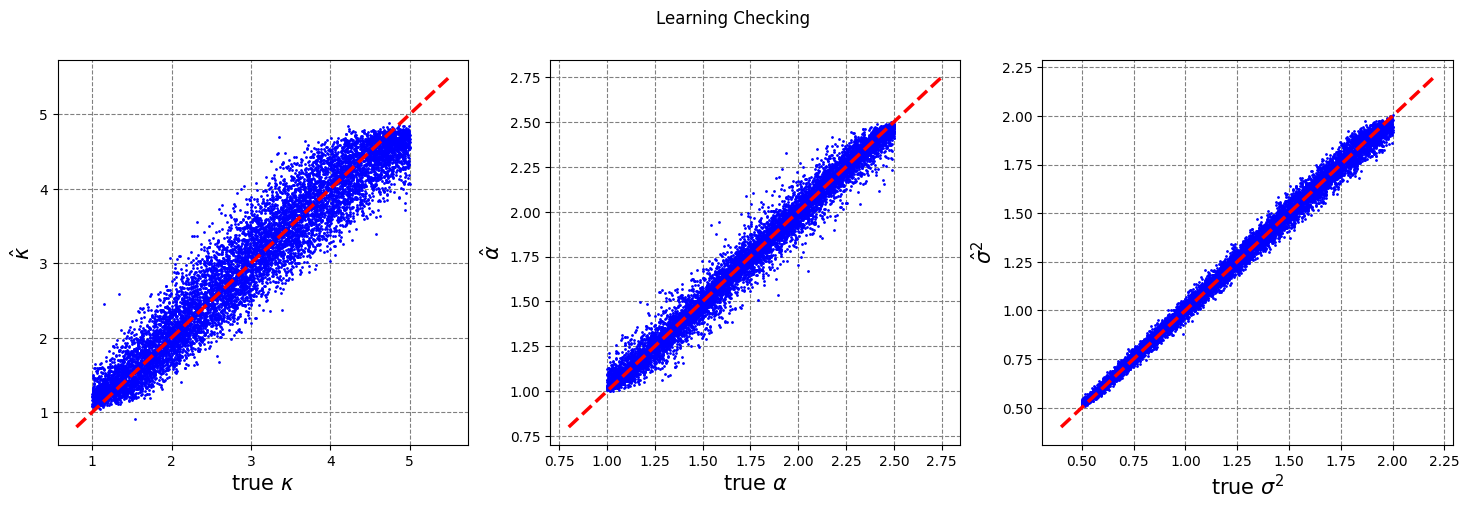

In [95]:
with torch.no_grad():
  net.eval()
  tmp1 = net(X_test.to('cpu'))[:,0]
  tmp2 = net(X_test.to('cpu'))[:,1]
  tmp3 = net(X_test.to('cpu'))[:,2]

  tmp1 = tmp1.detach().cpu().numpy().tolist()
  tmp2 = tmp2.detach().cpu().numpy().tolist()
  tmp3 = tmp3.detach().cpu().numpy().tolist()

mu_range = [1,5]
theta_range = [1,2.5]
sigma2_range = [0.5, 2]
# Plot for model checking
lim1 = [mu_range[0] * 0.8, mu_range[1] * 1.1]
lim2 = [theta_range[0] * 0.8, theta_range[1] * 1.1]
lim3 = [sigma2_range[0] * 0.8, sigma2_range[1] * 1.1]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
fig.suptitle('Learning Checking')

ax1.scatter(y_test[:,0], tmp1, marker='o', color='b', s = 1)
ax1.set_xlabel('true $\kappa$', fontsize=15)
ax1.set_ylabel('$\hat{\kappa}$', fontsize=15)
ax1.plot(np.linspace(lim1[0], lim1[1], 1000), np.linspace(lim1[0], lim1[1], 1000), color = "red", linestyle='dashed', linewidth = 2.5)
ax1.set_axisbelow(True)
ax1.grid(color='gray', linestyle='dashed')

ax2.scatter(y_test[:,1], tmp2, marker='o', color='b', s = 1)
ax2.set_xlabel(r'true $\alpha$', fontsize=15 )
ax2.set_ylabel(r'$\hat{\alpha}$', fontsize=15)
ax2.plot(np.linspace(lim2[0], lim2[1], 1000), np.linspace(lim2[0], lim2[1], 1000), color = "red", linestyle='dashed', linewidth = 2.5)
ax2.set_axisbelow(True)
ax2.grid(color='gray', linestyle='dashed')

ax3.scatter(y_test[:,2], tmp3, marker='o', color='b', s = 1)
ax3.set_xlabel('true $\sigma^2$', fontsize=15)
ax3.set_ylabel('$\hat{\sigma}^2$', fontsize=15)
ax3.plot(np.linspace(lim3[0], lim3[1], 1000), np.linspace(lim3[0], lim3[1], 1000), color = "red", linestyle='dashed', linewidth = 2.5)
ax3.set_axisbelow(True)
ax3.grid(color='gray', linestyle='dashed')

plt.show()

We will perform Bayesian inference for the test data that is used in Section 5.2. This code extract the test data

In [96]:
n = 3000
scenarios = ["S1", "S2", "S3"]
test_save_name = '../depot_hyun/hyun/test_data/OU_test_n'+ str(n) + '_' + scenarios[2] +'.pt'
test = torch.load(test_save_name)
print(test[1][1])

[3, 2, 1.0]


We already performed the exact MCMC method in `R` and import the samples that is generated from the exact posterior distribution.

In [97]:
import pandas as pd
import seaborn as sns
# CPU
torch.set_default_device("cpu")

# Read a CSV file into a DataFrame
df = pd.read_csv('OU_inference/MCMC/MC_results.txt', sep="\t")
MC_results = torch.tensor(df.values)
MC_results_np = MC_results.detach().cpu().numpy()


x0 = OU_summary(test[0][1])[0,:]
x0 = torch.reshape(x0, (1,5))
net = net.to("cpu")
net.eval()
print(x0)
print(torch.mean(MC_results,0))
print(net(x0))
MCMC_mean = torch.mean(MC_results,0)

tensor([[0.1778, 2.0249, 2.0251, 0.1870, 0.1868]])
tensor([2.5750, 2.0215, 0.9721], dtype=torch.float64)
tensor([[2.6025, 2.0256, 0.9767]], grad_fn=<AddmmBackward0>)


Here `conf_inf_sd` functions will perform Algorithm 2

In [98]:
x0 = OU_summary(test[0][1])[0,:]
x0 = torch.reshape(x0, (1,x0.size()[0]))

net.eval()
tmp = conf_inf_sd(x0, X_cal, Y_cal, net, .10)

est = net(x0)
est = est.detach().numpy().tolist()[0]
est[0]

train_loss: 0.208310  [   64/75250]
train_loss: 0.179080  [ 6464/75250]
train_loss: 0.177378  [12864/75250]
train_loss: 0.176455  [19264/75250]
train_loss: 0.144436  [25664/75250]
train_loss: 0.154878  [32064/75250]
train_loss: 0.130572  [38464/75250]
train_loss: 0.127681  [44864/75250]
train_loss: 0.120926  [51264/75250]
train_loss: 0.108276  [57664/75250]
train_loss: 0.096125  [64064/75250]
train_loss: 0.092754  [70464/75250]
Epoch 1
-------------------------------
train_loss 0.093442 val_loss 0.093692
Epoch 31
-------------------------------
train_loss 0.022528 val_loss 0.022891
train_loss: 0.022456  [   64/75250]
train_loss: 0.033936  [ 6464/75250]
train_loss: 0.020419  [12864/75250]
train_loss: 0.024528  [19264/75250]
train_loss: 0.024459  [25664/75250]
train_loss: 0.018731  [32064/75250]
train_loss: 0.024815  [38464/75250]
train_loss: 0.016794  [44864/75250]
train_loss: 0.024330  [51264/75250]
train_loss: 0.019968  [57664/75250]
train_loss: 0.023239  [64064/75250]
train_loss: 0.0

2.6024587154388428

Following code will provide you the results of inference

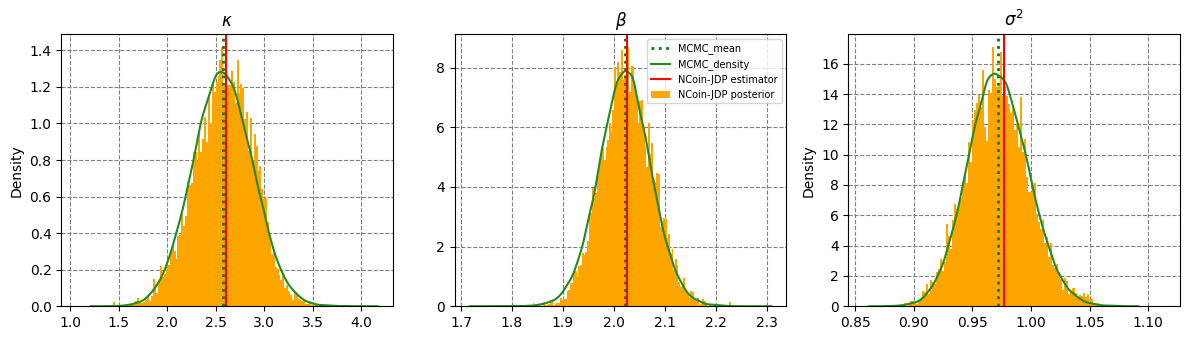

In [100]:
import matplotlib.pyplot as plt
var_name = [r'$\kappa$', r'$\beta$', r'$\sigma^2$']

fig, axs = plt.subplots(1, 3)
fig.set_figwidth(12)
fig.set_figheight(3.5)

for i in range(3):
    axs[i].hist( tmp[1][:,i].detach().cpu().numpy().tolist(), density=True, weights = tmp[0].numpy(), bins = 150, color = "orange")
    #axs[i].vlines(x = est[i], ymin = 0, ymax = ymax, color = "deeppink", linestyle ="dashdot", linewidth = 1)
    axs[i].set_axisbelow(True)
    axs[i].grid(color='gray', linestyle='dashed')
    axs[i].set_title(var_name[i])
    
    axs[0].set_ylabel('Density')
    axs[1].set_ylabel(None)
    axs[2].set_ylabel(None)
    
    axs[i].axvline(x = MCMC_mean[i], color = "green", linestyle = 'dotted', linewidth = 2)
    sns.kdeplot(x=MC_results_np[:,i], y=None, color = 'forestgreen', ax = axs[i])
    axs[i].axvline(x = est[i], color = "red")
    
    if i == 1:
        axs[i].legend(['MCMC_mean', 'MCMC_density', 'NCoin-JDP estimator', 'NCoin-JDP posterior'], 
                      loc = "best", fontsize=7, handlelength=2)
    
torch.set_default_device("cpu")
fig.tight_layout()
plt.savefig("plots/OU_tutorial.pdf") 